### 1. Парсинг данных

##### Получение html-кода 

In [108]:
# !pip install beautifulsoup4
# !pip install lxml
# !pip install fake_useragent
# !pip install ratelimit
# !pip install liac-arff
# !pip install tqdm

In [110]:
import re
import csv
import json
import arff
import requests
from time import sleep
import random
import datetime
import pandas as pd
import warnings
from tqdm import tqdm
from bs4 import BeautifulSoup
from dataclasses import dataclass
from fake_useragent import UserAgent
from ratelimit import limits, sleep_and_retry
warnings.filterwarnings("ignore", category=FutureWarning)

In [112]:
RATE_LIMIT = 3 # запрос
PERIOD = 1 # секунды
user = UserAgent().random
cookies_list = [
    {'__ddg8_': 'FHcrcvzIR5aNoI8q'}, 
    {'__ddg9_': '192.145.16.231'}, 
    {'__ddg10_': '1728403378'}, 
    {'__ddg1_': 'ozXLGaoPg49ztKmRoaql'}, 
    {'xid': 'kAkXe6hO69MG4ALTNsP0MdFJ1qDayxl1'}
]
cookies = random.choice(cookies_list)
headers = {'Accept': '*/*', 'User-Agent': user}

In [114]:
def create_tsv():
    filename = 'data.tsv'
    with open(filename, mode="w", newline="", encoding='utf-8') as file:
        writer = csv.writer(file, delimiter='\t')
        writer.writerow((
            'Production_series',
            'Optical_power',
            'Price_rub',
            'MKL_Diameter_mm',
            'Manufacturer',
            'Manufacture_country',
            'Brand',
            'Lens_type',
            'Moisture_content_%',
            'Oxygen_transmission_Dk/t',
            'Package_quantity_pieces',
            'Replacement_period',
            'Wearing_mode',
            'Curvature_radius',
            'Refractive_range',
            'Material'
        ))

In [116]:
def count_pages():
    create_tsv()
    base_url ='https://ochkarik.ru/contaktnie-linzy/'
    response = requests.get(base_url, headers=headers, cookies=cookies)
    soup = BeautifulSoup(response.text, 'lxml')
    return int(soup.find('ul', class_ = "pagers__list").find_all('a')[-2].text)

In [118]:
@sleep_and_retry
@limits(calls=RATE_LIMIT, period=PERIOD)
def get_url():
    for page in tqdm(range(0, count_pages)):
        # изготовили ссылку
        url = f'https://ochkarik.ru/?target=category_filter&action=filter&category_id=7&filter%5Bprice%5D%5B0%5D=&filter%5Bprice%5D%5B1%5D=&sortBy=popular&sortOrder=desc&pageId={page}'       
        # сходили по ссылке
        response = requests.get(url = url, headers = headers, cookies=cookies)
        # построили дерево
        soup_page = BeautifulSoup(response.text, 'lxml')
        lens_url = soup_page.find('div', class_ = 'product-grid__wrap').find_all('div', class_ = 'snippet')
        for item in lens_url:
            card_url = item.find('a', class_ = 'snippet__picture-link').get('href')
            resp = requests.get(url = card_url, headers = headers, cookies=cookies)
            yield resp
        

##### Разбор страниц

In [121]:
def get_data():
    for response in get_url():
        soup_card = BeautifulSoup(response.text, 'lxml')
        lens_data = []
        data = soup_card.find('div', class_ = 'section')
        try:
            Production_series = data.find('span', class_ = 'product-main-header__heading').find(itemprop="name").text.split('(')[0].replace(',', '.').strip().lower()
        except:
            Production_series = ''
        try:
            Optical_power = data.find_all('span',class_ = 'product-main-header__heading')[1].text.split('/')[0].replace(',', '.').replace('+', '').strip()
        except:
            Optical_power = ''
        try:
            start_marker = 'window.__VUE_APP_STATE__ = '
            start_index = response.text.find(start_marker)
            # Находим конец JSON-строки
            json_start = start_index + len(start_marker)
            json_end = response.text.find('};', json_start) + 1 # добавляем 1 для включения '}'
            json_data = response.text[json_start:json_end]
            # Загружаем JSON в словарь
            data_json = json.loads(json_data)
            Price = data_json.get("product-detail").get('product').get('price').replace(' ', '').replace(',', '.').strip()
        except:
            Price = ''
        MKL_Diameter = ''
        Manufacturer = ''
        Manufacture_country = ''
        Brand = ''
        Lens_type = ''
        Moisture_content = ''
        Oxygen_transmission = ''
        Package_quantity = ''
        Replacement_period = ''
        Wearing_mode = ''
        Curvature_radius = ''
        Refractive_range = ''
        Material = ''
        info = data.find_all('div', class_ = 'characteristics-item')
        for param in info:
            if param.find('div', class_ = 'characteristics-item-title').text.strip() == 'Диаметр МКЛ':
                try:
                    MKL_Diameter = param.find('p', class_ = 'characteristics-item-link characteristics-item-text').text.replace(',', '.').strip()
                except:
                    MKL_Diameter = ''
            elif param.find('div', class_ = 'characteristics-item-title').text.strip() == 'Производитель':
                try:
                    Manufacturer = param.find('a', class_ = 'characteristics-item-link').text.replace(' ', '').lower().strip().strip(',.')
                except:
                    Manufacturer = ''
            elif param.find('div', class_ = 'characteristics-item-title').text.strip() == 'Страна производства':
                try:
                    Manufacture_country = param.find('a', class_ = 'characteristics-item-link').text.lower().strip()
                except:
                    Manufacture_country = ''
            elif param.find('div', class_ = 'characteristics-item-title').text.strip() == 'Бренд':
                try:
                    Brand = param.find('a', class_ = 'characteristics-item-link').text.lower().replace(' ', '').strip()
                except:
                    Brand = ''
            elif param.find('div', class_ = 'characteristics-item-title').text.strip() == 'Тип линз':
                try:
                    Lens_type = param.find('a', class_ = 'characteristics-item-link').text.lower().strip()
                except:
                    Lens_type = ''
            elif param.find('div', class_ = 'characteristics-item-title').text.strip() == 'Влагосодержание, %':
                try:
                    Moisture_content = param.find('p', class_ = 'characteristics-item-link').text.replace('%', '').replace(',', '.').strip()
                except:
                    Moisture_content = ''
            elif param.find('div', class_ = 'characteristics-item-title').text.strip() == 'Коэффициент пропускания кислорода, Dk/t':
                try:
                    Oxygen_transmission = param.find('p', class_ = 'characteristics-item-link characteristics-item-text').text.replace(',', '.').strip()
                except:
                    Oxygen_transmission = ''
            elif param.find('div', class_ = 'characteristics-item-title').text.strip() == 'Количество блистеров в упаковке':
                try:
                    Package_quantity = param.find('a', class_ = 'characteristics-item-link').text.strip()
                except:
                    Package_quantity = ''
            elif param.find('div', class_ = 'characteristics-item-title').text.strip() == 'Срок замены':
                try:
                    Replacement_period = param.find('a', class_ = 'characteristics-item-link').text.lower().strip()
                except:
                    Replacement_period = ''
            elif param.find('div', class_ = 'characteristics-item-title').text.strip() == 'Режим ношения':
                try:
                    Wearing_mode = param.find('p', class_ = 'characteristics-item-link').text.replace(',', ';').lower().strip()
                except:
                    Wearing_mode = ''
            elif param.find('div', class_ = 'characteristics-item-title').text.strip() == 'Радиус кривизны':
                try:
                    Curvature_radius = param.find('p', class_ = 'characteristics-item-link').text.replace(',', '.').strip()
                except:
                    Curvature_radius = ''
            elif param.find('div', class_ = 'characteristics-item-title').text.strip() == 'Диапазон рефракций':
                try:
                    Refractive_range = param.find('p', class_ = 'characteristics-item-link').text.replace(',', '.').lower().strip()
                except:
                    Refractive_range = ''
            elif param.find('div', class_ = 'characteristics-item-title').text.strip() == 'Материал':
                try:
                    Material = param.find('p', class_ = 'characteristics-item-link').text.lower().strip()
                except:
                    Material = ''
        lens_data.append((
                Production_series,
                Optical_power,
                Price,
                MKL_Diameter,
                Manufacturer,
                Manufacture_country,
                Brand,
                Lens_type,
                Moisture_content,
                Oxygen_transmission,
                Package_quantity,
                Replacement_period,
                Wearing_mode,
                Curvature_radius,
                Refractive_range,
                Material
            ))
        write_tsv(lens_data)
        # time.sleep(1)
        # sleep(random.randrange(1, 2))
    # print(f"Данные успешно записаны в файл")

### 2. Запись в tsv формат

In [124]:
def write_tsv(data):
    filename = 'data.tsv'
    with open(filename, mode="a", newline="", encoding='utf-8') as file:
        writer = csv.writer(file, delimiter='\t')
        for item in data:
            writer.writerow(item)

In [126]:
count_pages = count_pages()
if __name__ == "__main__":
    # pages_count = count_pages()
    get_data()
    print(f"Данные успешно записаны в файл")

100%|█████████████████████████████████████| 1713/1713 [7:20:21<00:00, 15.42s/it]

Данные успешно записаны в файл


### 3. Запись в arff формат

##### Чтение данных из TSV файла

In [1014]:
tsv_file = 'data.tsv'
data = pd.read_csv(tsv_file, sep='\t')

##### Определение типов признаков и описание

In [1017]:
attributes = [
    '@ATTRIBUTE Production_series STRING',
    '@ATTRIBUTE Optical_power {-20.00, -19.50,-19.00, -18.50, -18.00, -17.50, -17.00, -16.50, -16.00, -15.50, -15.00, -14.50, -14.00, -13.50, -13.00, -12.50, -12.00, -11.50, -11.00, -10.50, -10.00, -9.75, -9.50, -9.25, -9.00, -8.75, -8.50, -8.25, -8.00, -7.75, -7.50, -7.25, -7.00, -6.75, -6.50, -6.25, -6.00, -5.75, -5.50, -5.25, -5.00, -4.75, -4.50, -4.25, -4.00, -3.75, -3.50, -3.25, -3.00, -2.75, -2.50, -2.25, -2.00, -1.75, -1.50, -1.25, -1.00, -0.75, -0.50, -0.25, 0.00, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50, 2.75, 3.00, 3.25, 3.50, 3.75, 4.00, 4.25, 4.50, 4.75, 5.00, 5.25, 5.50, 5.75,  6.00, 6.50, 7.00, 7.50, 8.00, 8.50, 9.00, 9.50, 10.00, 10.50, 11.00, 11.50, 12.00, 12.50, 13.00, 13.50, 14.00, 14.50, 15.00, 15.50, 16.00, 16.50, 17.00, 17.50, 18.00, 18.50, 19.00, 19.50, 20.00}',
    '@ATTRIBUTE Price NUMERIC',
    '@ATTRIBUTE MKL_Diameter NUMERIC',
    '@ATTRIBUTE Manufacturer {alcon, bausch&lomb, clearlab, coopervision, johnson&johnson, maxima optics, maxlook, menicon, optosoft, unicon optical co}',
    '@ATTRIBUTE Manufacture_country STRING',
    '@ATTRIBUTE Brand {acuvue, dailies, biofinity, purevision, air optix, biomedics, amore, avaira, bausch&lomb, biotruе, clariti, clear, freshlook, iqlens, maxima, miru, myday, optima, optosoft, precision, premio, proclear, soflens, total, ultra}',
    '@ATTRIBUTE Lens_type {астигматические, асферические, мультифокальные, прозрачные, цветные}',
    '@ATTRIBUTE Moisture_content NUMERIC',
    '@ATTRIBUTE Oxygen_transmission NUMERIC',
    '@ATTRIBUTE Package_quantity {1, 2, 3, 4, 6, 12, 24, 30, 90, 180}',
    '@ATTRIBUTE Replacement_period {один день, две недели, один месяц, три месяца, шесть месяцев}',
    '@ATTRIBUTE Wearing_mode STRING',
    '@ATTRIBUTE Curvature_radius STRING',
    '@ATTRIBUTE Refractive_range STRING',
    '@ATTRIBUTE Material {силикон-гидрогель, водоградиентный, гидрогель, гипергель}',    
]

##### Запись данных в arff файл

In [1020]:
arff_file = 'data.arff' 

In [1022]:
with open(arff_file, mode='w', encoding='utf-8') as f:
    # Записываем заголовок arff
    f.write('@RELATION dataset\n\n')
    
    # Записываем атрибуты
    for attribute in attributes:
        f.write(attribute + '\n')
    
    f.write('\n@DATA\n')
    
    # Записываем данные
    for index, row in data.iterrows():
        # Преобразуем строку в формат arff
        row_data = ', '.join(map(lambda x: str(x), row))
        f.write(row_data + "\n")

print(f'Файл arff успешно создан: {arff_file}')

Файл arff успешно создан: data.arff


### 4. Предобработка данных

In [943]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from category_encoders.binary import BinaryEncoder
from sklearn.preprocessing import MinMaxScaler

In [944]:
file_path = 'data.tsv'
df_base = pd.read_csv(file_path, sep='\t')
df = df_base.copy()

In [945]:
df.head()

,Production_series,Optical_power,Price_rub,MKL_Diameter_mm,Manufacturer,Manufacture_country,Brand,Lens_type,Moisture_content_%,Oxygen_transmission_Dk/t,Package_quantity_pieces,Replacement_period,Wearing_mode,Curvature_radius,Refractive_range,Material
0,acuvue oasys with hydraclear plus,-1.00,1680,14.0,johnson&johnson,сша/ирландия,acuvue,прозрачные,38.0,147.0,6,две недели,дневной; допускается непрерывное ношение до 7 ...,8.4; 8.8,от -12.0d до +8.0d,силикон-гидрогель
1,air optix plus hydraglyde,-1.00,1380,14.2,alcon,малайзия/индонезия,airoptix,прозрачные,33.0,138.0,3,один месяц,дневной; допускается непрерывное ношение до 6 ...,8.6,от -12.0d до +8.0d,силикон-гидрогель
2,total30,-1.00,2120,NaN,alcon,германия,total,прозрачные,55.0,154.0,3,один месяц,дневной,8.4,от -12.0d до +6.0d,водоградиентный
3,precision1 for astigmatism,-1.25,2580,14.5,alcon,германия,precision,астигматические,87.0,90.0,30,один день,дневной,8.5,от -8.0d до +4.0d,силикон-гидрогель
4,total30 for astigmatism,-1.00,2580,NaN,alcon,германия,total,астигматические,55.0,123.0,3,один месяц,дневной,8.6,от -8.0d до +4.0d,водоградиентный


##### Выбор целевого признака

In [947]:
target_column = 'Replacement_period'  # Укажите имя вашего целевого признака
target_data = df[target_column]
target_data.head()

0    две недели
1    один месяц
2    один месяц
3     один день
4    один месяц
Name: Replacement_period, dtype: object

#### Обработка пропусков

In [954]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51381 entries, 0 to 51380
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Production_series         51381 non-null  object 
 1   Optical_power             51380 non-null  float64
 2   Price_rub                 51381 non-null  int64  
 3   MKL_Diameter_mm           44826 non-null  float64
 4   Manufacturer              51381 non-null  object 
 5   Manufacture_country       51381 non-null  object 
 6   Brand                     51381 non-null  object 
 7   Lens_type                 51381 non-null  object 
 8   Moisture_content_%        51381 non-null  float64
 9   Oxygen_transmission_Dk/t  51381 non-null  float64
 10  Package_quantity_pieces   51381 non-null  int64  
 11  Replacement_period        51381 non-null  object 
 12  Wearing_mode              51381 non-null  object 
 13  Curvature_radius          51381 non-null  object 
 14  Refrac

In [955]:
df.describe()

,Optical_power,Price_rub,MKL_Diameter_mm,Moisture_content_%,Oxygen_transmission_Dk/t,Package_quantity_pieces
count,51380.000000,51381.000000,44826.000000,51381.000000,51381.000000,51381.000000
mean,-1.127890,3021.308888,14.443223,51.334602,101.204510,13.738035
std,4.583817,1048.262133,0.132610,12.620644,33.081065,18.847255
min,-20.000000,910.000000,13.800000,24.000000,14.200000,1.000000
25%,-4.500000,2380.000000,14.500000,48.000000,90.000000,3.000000
50%,-1.500000,2580.000000,14.500000,48.000000,116.000000,6.000000
75%,2.250000,3980.000000,14.500000,55.000000,116.000000,30.000000
max,20.000000,12360.000000,14.500000,87.000000,175.000000,180.000000


In [956]:
df.isnull().sum()

Production_series               0
Optical_power                   1
Price_rub                       0
MKL_Diameter_mm              6555
Manufacturer                    0
Manufacture_country             0
Brand                           0
Lens_type                       0
Moisture_content_%              0
Oxygen_transmission_Dk/t        0
Package_quantity_pieces         0
Replacement_period              0
Wearing_mode                    0
Curvature_radius                0
Refractive_range            12810
Material                        0
dtype: int64

In [957]:
for col in df.columns:
    print(f'{col}: {df[col].isna().sum() / df.shape[0] * 100:.2f}%')

Production_series: 0.00%
Optical_power: 0.00%
Price_rub: 0.00%
MKL_Diameter_mm: 12.76%
Manufacturer: 0.00%
Manufacture_country: 0.00%
Brand: 0.00%
Lens_type: 0.00%
Moisture_content_%: 0.00%
Oxygen_transmission_Dk/t: 0.00%
Package_quantity_pieces: 0.00%
Replacement_period: 0.00%
Wearing_mode: 0.00%
Curvature_radius: 0.00%
Refractive_range: 24.93%
Material: 0.00%


In [958]:
df.shape

(51381, 16)

##### Количественные признаки

In [960]:
df['Optical_power'].value_counts()

Optical_power
-1.50     1107
-4.00     1107
-3.50     1100
-6.00     1098
-5.75     1096
          ... 
 20.00       1
 10.50       1
 18.50       1
 19.00       1
-17.50       1
Name: count, Length: 111, dtype: int64

In [961]:
df.dropna(subset=['Optical_power'], axis=0, inplace=True)
df.shape

(51380, 16)

##### Качественные признаки

In [963]:
df['MKL_Diameter_mm'].value_counts()

MKL_Diameter_mm
14.5    36870
14.3     2946
14.2     2573
14.0     1833
14.1      517
13.8       86
Name: count, dtype: int64

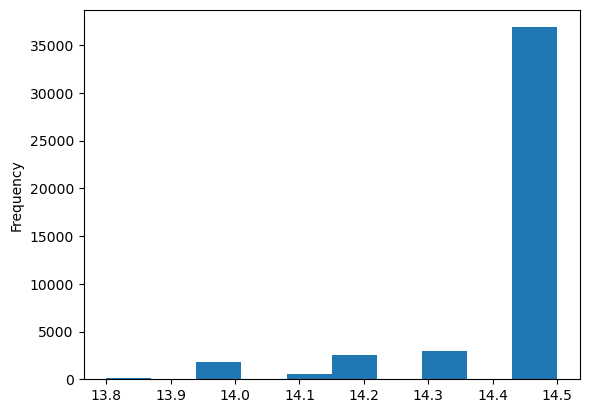

In [964]:
df['MKL_Diameter_mm'].plot(kind='hist', bins=10);

In [965]:
df['MKL_Diameter_mm'].mode()

0    14.5
Name: MKL_Diameter_mm, dtype: float64

In [966]:
df['MKL_Diameter_mm'].fillna(df['MKL_Diameter_mm'].mode().iloc[0], inplace=True)

In [967]:
# df['Refractive_range'].fillna('нет данных', inplace=True)

##### Удаление ненужных признаков

In [973]:
df.drop(['Refractive_range', 'Wearing_mode', 'Production_series', 'Curvature_radius', 'Manufacture_country'], axis=1, inplace=True)
df.head()

,Optical_power,Price_rub,MKL_Diameter_mm,Manufacturer,Brand,Lens_type,Moisture_content_%,Oxygen_transmission_Dk/t,Package_quantity_pieces,Replacement_period,Material
0,-1.00,1680,14.0,johnson&johnson,acuvue,прозрачные,38.0,147.0,6,две недели,силикон-гидрогель
1,-1.00,1380,14.2,alcon,airoptix,прозрачные,33.0,138.0,3,один месяц,силикон-гидрогель
2,-1.00,2120,14.5,alcon,total,прозрачные,55.0,154.0,3,один месяц,водоградиентный
3,-1.25,2580,14.5,alcon,precision,астигматические,87.0,90.0,30,один день,силикон-гидрогель
4,-1.00,2580,14.5,alcon,total,астигматические,55.0,123.0,3,один месяц,водоградиентный


In [974]:
df.isnull().sum()

Optical_power               0
Price_rub                   0
MKL_Diameter_mm             0
Manufacturer                0
Brand                       0
Lens_type                   0
Moisture_content_%          0
Oxygen_transmission_Dk/t    0
Package_quantity_pieces     0
Replacement_period          0
Material                    0
dtype: int64

In [975]:
df.shape

(51380, 11)

#### Преобразование нецелевых категорий

##### Ordinal Encoding

In [989]:
# Optical_power
# Создаем упорядоченный список категорий
Opt_power = [-20.00, -19.50, -19.00, -18.50, -18.00, -17.50, -17.00, -16.50, -16.00, -15.50, -15.00, -14.50, -14.00, -13.50, -13.00, -12.50, -12.00, -11.50, -11.00, -10.50, -10.00, -9.75, -9.50, -9.25, -9.00, -8.75, -8.50, -8.25, -8.00, -7.75, -7.50, -7.25, -7.00, -6.75, -6.50, -6.25, -6.00, -5.75, -5.50, -5.25, -5.00, -4.75, -4.50, -4.25, -4.00, -3.75, -3.50, -3.25, -3.00, -2.75, -2.50, -2.25, -2.00, -1.75, -1.50, -1.25, -1.00, -0.75, -0.50, -0.25, 0.00, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50, 2.75, 3.00, 3.25, 3.50, 3.75, 4.00, 4.25, 4.50, 4.75, 5.00, 5.25, 5.50, 5.75,  6.00, 6.50, 7.00, 7.50, 8.00, 8.50, 9.00, 9.50, 10.00, 10.50, 11.00, 11.50, 12.00, 12.50, 13.00, 13.50, 14.00, 14.50, 15.00, 15.50, 16.00, 16.50, 17.00, 17.50, 18.00, 18.50, 19.00, 19.50, 20.00]

# Инициализируем OrdinalEncoder
encoder = OrdinalEncoder(categories = [Opt_power])

# Преобразуем столбец 'Optical_power'
df['Optical_power'] = encoder.fit_transform(df[['Optical_power']])

# df[['Optical_power','Optical_power_encoded']].head()

In [990]:
# Package_quantity_pieces
# Создаем упорядоченный список категорий
Package_quantity = [1, 2, 3, 4, 6, 12, 24, 30, 90, 180]

# Инициализируем OrdinalEncoder
encoder = OrdinalEncoder(categories = [Package_quantity])

# Преобразуем столбец 'Package_quantity_pieces'
df['Package_quantity_pieces'] = encoder.fit_transform(df[['Package_quantity_pieces']])

# df[['Package_quantity_pieces','Package_quantity_pieces_encoded']].head()

##### One-hot Encoding

In [993]:
# Lens_type
# Инициализируем OneHotEncoder
encoder = OneHotEncoder(drop = 'first', sparse_output = False)

# Преобразуем столбец 'Lens_type'
onehot_columns = encoder.fit_transform(df[['Lens_type']])

# Создаем датафрейм с новыми столбцами
encoded_df = pd.DataFrame(onehot_columns, columns=encoder.get_feature_names_out(['Lens_type']))

encoded_columns_name = encoder.get_feature_names_out(['Lens_type'])
df.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)

df = pd.concat([df, encoded_df], axis=1)

df.drop('Lens_type', axis = 1, inplace = True)
df.head()

,Optical_power,Price_rub,MKL_Diameter_mm,Manufacturer,Brand,Moisture_content_%,Oxygen_transmission_Dk/t,Package_quantity_pieces,Replacement_period,Material,Lens_type_асферические,Lens_type_мультифокальные,Lens_type_прозрачные,Lens_type_цветные
0,56.0,1680,14.0,johnson&johnson,acuvue,38.0,147.0,4.0,две недели,силикон-гидрогель,0.0,0.0,1.0,0.0
1,56.0,1380,14.2,alcon,airoptix,33.0,138.0,2.0,один месяц,силикон-гидрогель,0.0,0.0,1.0,0.0
2,56.0,2120,14.5,alcon,total,55.0,154.0,2.0,один месяц,водоградиентный,0.0,0.0,1.0,0.0
3,55.0,2580,14.5,alcon,precision,87.0,90.0,7.0,один день,силикон-гидрогель,0.0,0.0,0.0,0.0
4,56.0,2580,14.5,alcon,total,55.0,123.0,2.0,один месяц,водоградиентный,0.0,0.0,0.0,0.0


In [995]:
# Manufacturer
# Инициализируем OneHotEncoder
encoder = OneHotEncoder(drop = 'first', sparse_output = False)

# Преобразуем столбец 'Manufacturer'
onehot_columns = encoder.fit_transform(df[['Manufacturer']])

# Создаем датафрейм с новыми столбцами
encoded_df = pd.DataFrame(onehot_columns, columns=encoder.get_feature_names_out(['Manufacturer']))

encoded_columns_name = encoder.get_feature_names_out(['Manufacturer'])
df = pd.concat([df, encoded_df], axis=1)

df.drop('Manufacturer', axis = 1, inplace = True)
df.head()

,Optical_power,Price_rub,MKL_Diameter_mm,Brand,Moisture_content_%,Oxygen_transmission_Dk/t,Package_quantity_pieces,Replacement_period,Material,Lens_type_асферические,...,Lens_type_цветные,Manufacturer_bausch&lomb,Manufacturer_clearlab,Manufacturer_coopervision,Manufacturer_johnson&johnson,Manufacturer_maximaoptics,Manufacturer_maxlook,Manufacturer_menicon,Manufacturer_optosoft,Manufacturer_uniconopticalco
0,56.0,1680,14.0,acuvue,38.0,147.0,4.0,две недели,силикон-гидрогель,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,56.0,1380,14.2,airoptix,33.0,138.0,2.0,один месяц,силикон-гидрогель,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,56.0,2120,14.5,total,55.0,154.0,2.0,один месяц,водоградиентный,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,55.0,2580,14.5,precision,87.0,90.0,7.0,один день,силикон-гидрогель,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,56.0,2580,14.5,total,55.0,123.0,2.0,один месяц,водоградиентный,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [996]:
# Material
# Инициализируем OneHotEncoder
encoder = OneHotEncoder(drop = 'first', sparse_output = False)

# Преобразуем столбец 'Material'
onehot_columns = encoder.fit_transform(df[['Material']])

# Создаем датафрейм с новыми столбцами
encoded_df = pd.DataFrame(onehot_columns, columns=encoder.get_feature_names_out(['Material']))

encoded_columns_name = encoder.get_feature_names_out(['Material'])
df = pd.concat([df, encoded_df], axis=1)

df.drop('Material', axis = 1, inplace = True)
df.head()

,Optical_power,Price_rub,MKL_Diameter_mm,Brand,Moisture_content_%,Oxygen_transmission_Dk/t,Package_quantity_pieces,Replacement_period,Lens_type_асферические,Lens_type_мультифокальные,...,Manufacturer_coopervision,Manufacturer_johnson&johnson,Manufacturer_maximaoptics,Manufacturer_maxlook,Manufacturer_menicon,Manufacturer_optosoft,Manufacturer_uniconopticalco,Material_гидрогель,Material_гипергель,Material_силикон-гидрогель
0,56.0,1680,14.0,acuvue,38.0,147.0,4.0,две недели,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,56.0,1380,14.2,airoptix,33.0,138.0,2.0,один месяц,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,56.0,2120,14.5,total,55.0,154.0,2.0,один месяц,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,55.0,2580,14.5,precision,87.0,90.0,7.0,один день,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,56.0,2580,14.5,total,55.0,123.0,2.0,один месяц,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Binary Encoding

In [1000]:
# Brand
# Инициализируем BinaryEncoder
encoder = BinaryEncoder()

# Преобразуем столбец 'Brand'
df_encoded = encoder.fit_transform(df[['Brand']])

# Объединяем новый датафрейм с исходным
df = pd.concat([df, df_encoded], axis=1)

# Удаляем исходный столбец 'Brand'
df.drop('Brand', axis=1, inplace=True)
df.head()

,Optical_power,Price_rub,MKL_Diameter_mm,Moisture_content_%,Oxygen_transmission_Dk/t,Package_quantity_pieces,Replacement_period,Lens_type_асферические,Lens_type_мультифокальные,Lens_type_прозрачные,...,Manufacturer_optosoft,Manufacturer_uniconopticalco,Material_гидрогель,Material_гипергель,Material_силикон-гидрогель,Brand_0,Brand_1,Brand_2,Brand_3,Brand_4
0,56.0,1680,14.0,38.0,147.0,4.0,две недели,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0,0,0,0,1
1,56.0,1380,14.2,33.0,138.0,2.0,один месяц,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0,0,0,1,0
2,56.0,2120,14.5,55.0,154.0,2.0,один месяц,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,1,1
3,55.0,2580,14.5,87.0,90.0,7.0,один день,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0,0,1,0,0
4,56.0,2580,14.5,55.0,123.0,2.0,один месяц,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,1,1


In [1001]:
df.shape

(51380, 28)

#### Нормализация данных

In [1004]:
scaler = MinMaxScaler()
df[['Price_rub', 'MKL_Diameter_mm', 'Moisture_content_%', 'Oxygen_transmission_Dk/t']] = scaler.fit_transform(df[['Price_rub', 'MKL_Diameter_mm', 'Moisture_content_%', 'Oxygen_transmission_Dk/t']])
df.head()

,Optical_power,Price_rub,MKL_Diameter_mm,Moisture_content_%,Oxygen_transmission_Dk/t,Package_quantity_pieces,Replacement_period,Lens_type_асферические,Lens_type_мультифокальные,Lens_type_прозрачные,...,Manufacturer_optosoft,Manufacturer_uniconopticalco,Material_гидрогель,Material_гипергель,Material_силикон-гидрогель,Brand_0,Brand_1,Brand_2,Brand_3,Brand_4
0,56.0,0.067249,0.285714,0.222222,0.825871,4.0,две недели,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0,0,0,0,1
1,56.0,0.041048,0.571429,0.142857,0.769900,2.0,один месяц,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0,0,0,1,0
2,56.0,0.105677,1.000000,0.492063,0.869403,2.0,один месяц,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,1,1
3,55.0,0.145852,1.000000,1.000000,0.471393,7.0,один день,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0,0,1,0,0
4,56.0,0.145852,1.000000,0.492063,0.676617,2.0,один месяц,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,1,1


### 5. Запись в scv формат

In [1009]:
df.to_csv('data.csv', index=False, encoding='utf-8')